https://www.kaggle.com/paulorzp/gmean-of-light-gbm-models-lb-0-95x

In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import featuretools as ft
import lightgbm as lgb
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

%matplotlib inline
RSEED = 50

In [2]:
all_files = ['./data/baseline_log_hour.csv',
            './data/baseline_log_rmdata.csv']

In [3]:
outs = [pd.read_csv(all_files[f], index_col=0) for f in range(0,len(all_files))]
all_sub = pd.concat(outs, axis=1)
cols = list(map(lambda x: "sub" + str(x), range(len(all_sub.columns))))
all_sub.columns = cols
all_sub.reset_index(inplace=True)

/home/jinpwa/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
all_sub.head()

,row_id,sub0,sub1
0,0,78.317253,140.303382
1,1,45.318975,90.374704
2,2,5.382445,6.973330
3,3,85.505552,239.574698
4,4,468.741737,1080.890309


In [5]:
# calculate correlation of submissions
corr = all_sub.iloc[:,1:].corr()

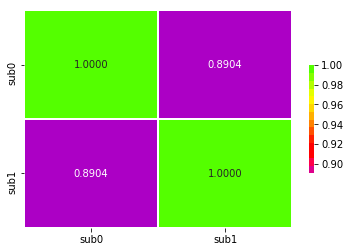

In [7]:
sns.heatmap(corr,cmap='prism',center=0, linewidths=1,
            annot=True,fmt='.4f', cbar_kws={"shrink":.5})

# Simple Average

In [8]:
all_sub['meter_reading'] = all_sub.iloc[:,1:].mean(axis=1)
all_sub.head()

,row_id,sub0,sub1,meter_reading
0,0,78.317253,140.303382,109.310317
1,1,45.318975,90.374704,67.846839
2,2,5.382445,6.973330,6.177887
3,3,85.505552,239.574698,162.540125
4,4,468.741737,1080.890309,774.816023


In [11]:
all_sub[all_sub.meter_reading < 0]

,row_id,sub0,sub1,meter_reading


In [10]:
all_sub.loc[all_sub.meter_reading < 0, 'meter_reading'] = 0

In [12]:
all_sub[['row_id','meter_reading']].to_csv('./data/blend2_sa_rmneg.csv',index=False)

# Weighted GMEAN by inverse correlation

In [7]:
corr_rank = np.tril(all_sub.iloc[:,1:].corr().values,0)+np.triu(np.ones(corr.shape),1)
corr_rank

array([[1.        , 1.        , 1.        ],
       [0.89037208, 1.        , 1.        ],
       [1.        , 0.89037208, 1.        ]])

In [8]:
# calculate how many times of blend is needed
blend_times = (corr_rank>0).sum() - (corr_rank>0.99).sum()
blend_times

2

In [9]:
m_gmean, weight_sum = 0, 0

In [10]:
# https://en.wikipedia.org/wiki/Weighted_geometric_mean
for i in range(blend_times):
    min_corr_indexs = np.unravel_index(corr_rank.argmin(), corr_rank.shape)
    print('%s round with current minimual index%s'%(i,min_corr_indexs))
    # weight decay with higher correlations
    weight = (blend_times-i)/blend_times
    m_gmean += weight*(np.log(all_sub.iloc[:,min_corr_indexs[0]+1])+np.log(all_sub.iloc[:,min_corr_indexs[1]+1]))/2
    print(m_gmean.head())
    weight_sum += weight
    print('current weight:%s, total weight:%s'%(weight,weight_sum))
    corr_rank[min_corr_indexs] = 1
    print(corr_rank)

0 round with current minimual index(1, 0)
0    4.652288
1    4.158845
2    1.812618
3    4.963723
4    6.567796
dtype: float64
current weight:1.0, total weight:1.0
[[1.         1.         1.        ]
 [1.         1.         1.        ]
 [1.         0.89037208 1.        ]]
1 round with current minimual index(2, 1)
0    6.978431
1    6.238268
2    2.718927
3    7.445585
4    9.851694
dtype: float64
current weight:0.5, total weight:1.5
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]


In [11]:
m_gmean = np.exp(m_gmean/weight_sum)
m_gmean.head()

0    104.824498
1     63.997570
2      6.126464
3    143.125703
4    711.799410
dtype: float64

In [12]:
m_gmean = (m_gmean-m_gmean.min())/(m_gmean.max()-m_gmean.min())
m_gmean.head()

0    0.001712
1    0.001045
2    0.000100
3    0.002338
4    0.011626
dtype: float64

In [13]:
all_sub['meter_reading'] = m_gmean
all_sub.tail()

,row_id,sub0,sub1,sub2,meter_reading
41697595,41696866,3969.969204,3969.969204,3969.969204,0.064842
41697596,41697101,195.630860,185.795213,195.630860,0.003114
41697597,41697116,3955.533465,3955.533465,3955.533465,0.064607
41697598,41697351,198.366526,188.394038,198.366526,0.003157
41697599,41697366,3955.533465,3955.533465,3955.533465,0.064607


In [14]:
all_sub[['TransactionID','isFraud']].to_csv('./data/sub_1001_gmean.csv',index=False)